In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})

## Exercise 1: explore filter parameters

In this exercise you will explore how different parameters affect the filtering process.

Import the data from data/moving_lfp.pickle (the file is already on your machine if you run the download_data() cell in the main lesson)

In [3]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/7BosHgemAseANIc')

Take a few seconds of the data, and filter them in different frequency bands. PLot the resulting signal. Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.

In [4]:
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp_full = lfp_data['lfp']
lfp = lfp_full[3000:5000]
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 2.0 seconds of LFP, sampled at 1000.0 Hz


In [7]:
from scipy.fft import fft, fftfreq

n_samples = len(lfp)
sample_dt = 1. / sampling_rate

# we subtract the mean to get rid of the 0 frequency component in the spectrum
centered_lfp = lfp - np.mean(lfp)

transformed_signal = fft(centered_lfp) 

frequencies = fftfreq(n_samples,sample_dt) 

transformed_signal = transformed_signal[:n_samples//2]
frequencies = frequencies[:n_samples//2]

power = abs(transformed_signal)**2

#plt.figure(figsize = (10,5))
#plt.plot(frequencies,power)
#plt.xlim([0,100]) # restrict to 
#plt.axvline(x=8 ,c='r',linestyle='--',label='8 Hz theta')
#plt.axvline(x=50 ,c='grey',linestyle='--',label='50 Hz electrical noise')

#plt.legend()


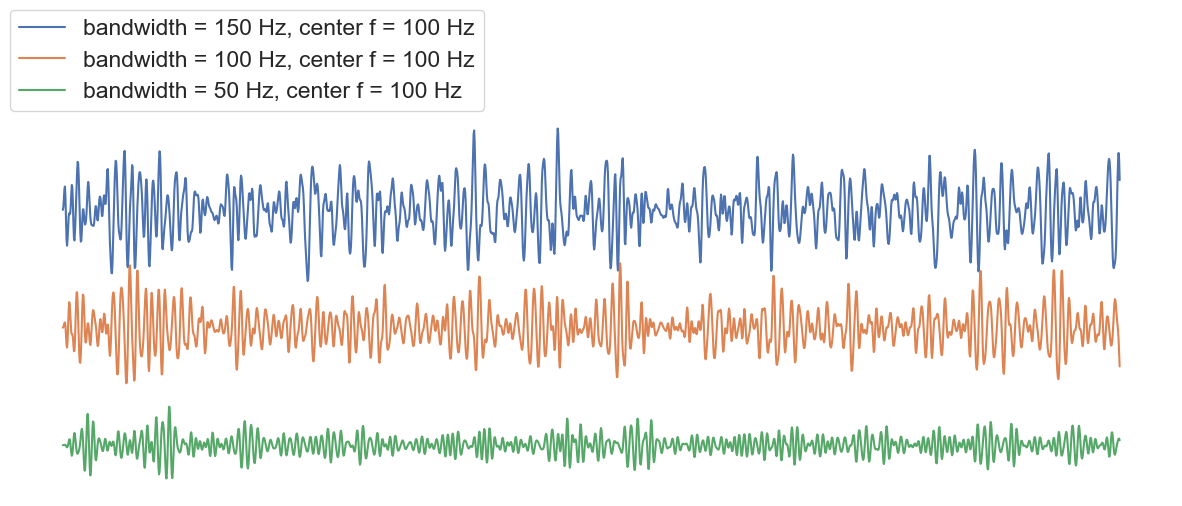

In [8]:
from scipy.signal import butter
from scipy.signal import sosfilt

filter_order = 5 #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability
    
def filterf(bandwidth, center_f, order):
    low_f = center_f - bandwidth/2
    high_f = center_f + bandwidth/2
    filter_order = order
    filter = butter(filter_order,[low_f,high_f],
                btype='band', 
                output='sos', 
                fs=sampling_rate)
    return filter

#three different bandwidths for fixed central frequency
filter = filterf(150,100,5)
wideband_lfp = sosfilt(filter, lfp)

filter = filterf(100,100,5)
middleband_lfp = sosfilt(filter,lfp)

filter = filterf(50,100,5)
narrowband_lfp = sosfilt(filter,lfp)


plot_offset = 400 #to plot the signal on different lines

plt.figure(figsize=(15,5))
plt.plot(wideband_lfp+2*plot_offset,label='bandwidth = 150 Hz, center f = 100 Hz')
plt.plot(middleband_lfp+plot_offset,label='bandwidth = 100 Hz, center f = 100 Hz')
plt.plot(narrowband_lfp,label='bandwidth = 50 Hz, center f = 100 Hz')

plt.axis('off')
plt.legend(loc=(0,1))


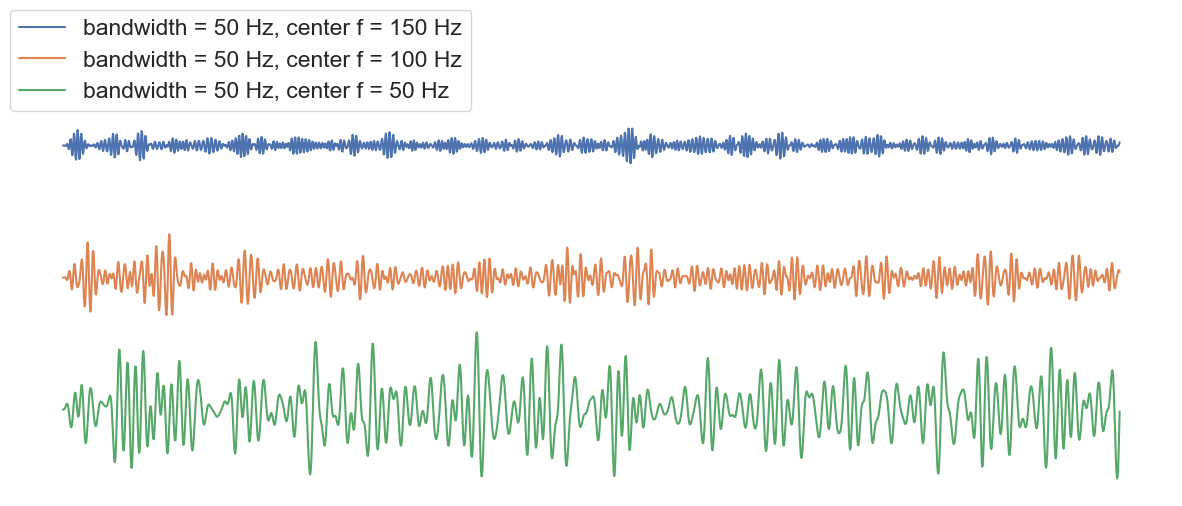

In [9]:
#three different central frequencies for fixed bandwidth
filter = filterf(50,150,5)
central150 = sosfilt(filter, lfp)

filter = filterf(50,100,5)
central100 = sosfilt(filter,lfp)

filter = filterf(50,50,5)
central50 = sosfilt(filter,lfp)

plot_offset = 400 #to plot the signal on different lines

plt.figure(figsize=(15,5))
plt.plot(central150+2*plot_offset,label='bandwidth = 50 Hz, center f = 150 Hz')
plt.plot(central100+plot_offset,label='bandwidth = 50 Hz, center f = 100 Hz')
plt.plot(central50,label='bandwidth = 50 Hz, center f = 50 Hz')

plt.axis('off')
plt.legend(loc=(0,1))


Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command %timeit )

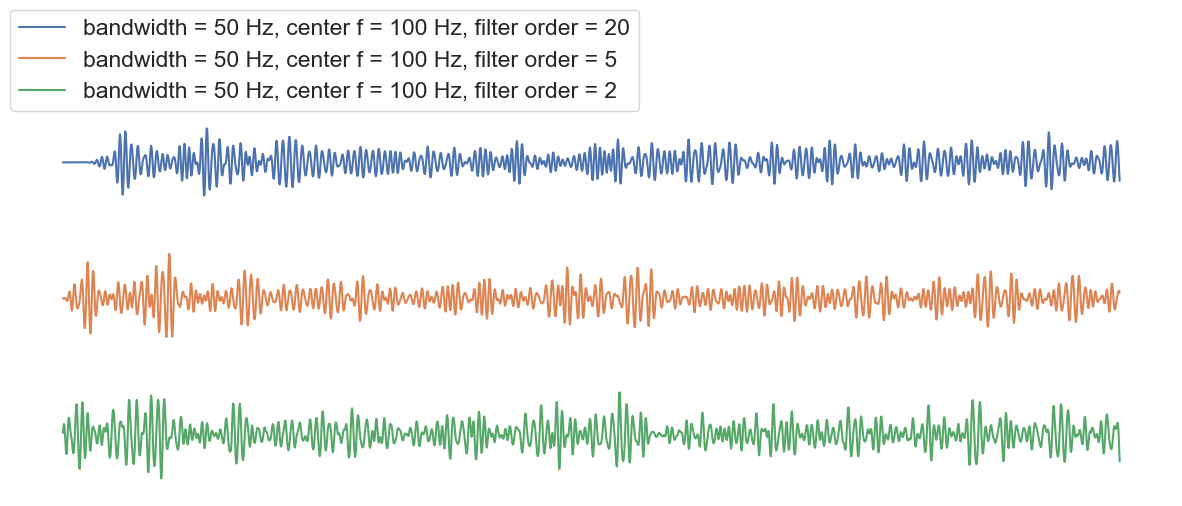

In [10]:
#three different filter orders for fixed bandwidth and central frequency
filter = filterf(50,100,20)
filter7 = sosfilt(filter, lfp)

filter = filterf(50,100,5)
filter5 = sosfilt(filter,lfp)

filter = filterf(50,100,2)
filter3 = sosfilt(filter,lfp)

plot_offset = 400 #to plot the signal on different lines

plt.figure(figsize=(15,5))
plt.plot(filter7+2*plot_offset,label='bandwidth = 50 Hz, center f = 100 Hz, filter order = 20')
plt.plot(filter5+plot_offset,label='bandwidth = 50 Hz, center f = 100 Hz, filter order = 5')
plt.plot(filter3,label='bandwidth = 50 Hz, center f = 100 Hz, filter order = 2')

plt.axis('off')
plt.legend(loc=(0,1))

Comment on what you see

The larger the bandwidth the higher the amplitude of the signal. The smaller the center frequency the larger the amplitude of the signal. The filter order shifts the signal. The larger filter order the more the signal is shifted to the right. Furthermore, the signal is changes slightly. 

## Exercise 2: wavelet transform with real wavelets

In thin exercise you will explore the difference between real and complex wavelets in the continuous wavelet transform.

Import the data from data/moving_lfp.pickle

In [11]:
# Downloaded before, in exercise 1
#download_data('https://surfdrive.surf.nl/files/index.php/s/7BosHgemAseANIc')

Select a period of a few seconds of the signal and compute the spectrogram. Try the wavelet transform with wavelet mexh (mexican hat), gaus (gaussian) and morl (morlet). These are all real wavelets.

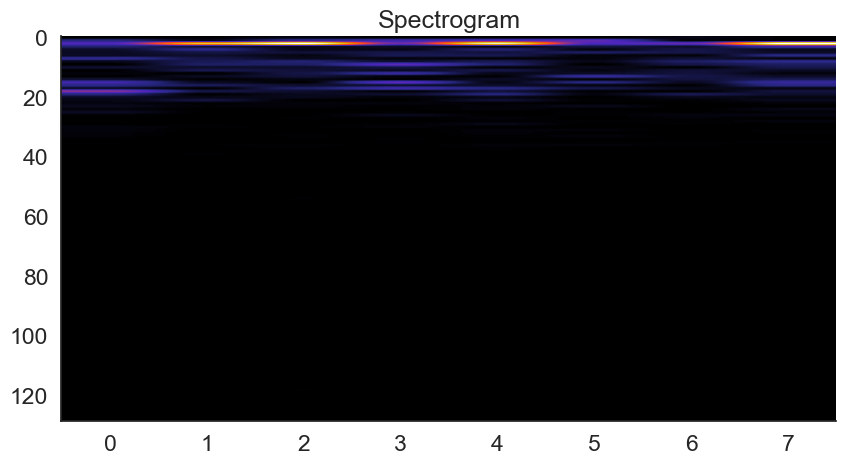

interactive(children=(FloatSlider(value=0.5, description='scale', max=2.0, min=0.05), FloatSlider(value=5.0, d…

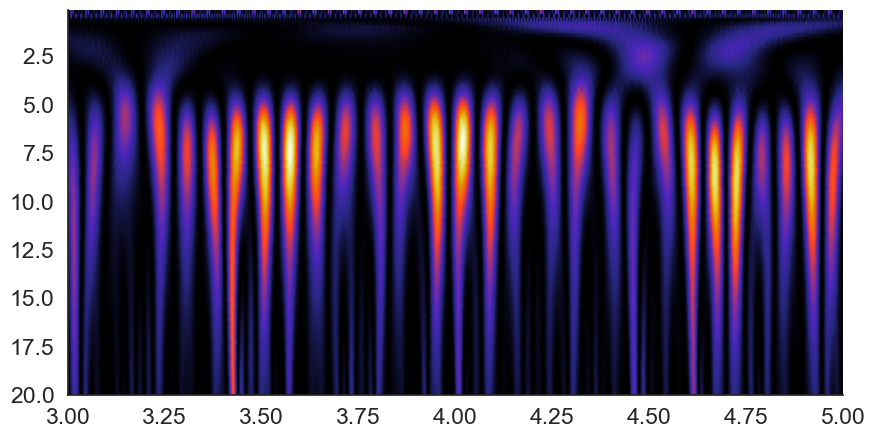

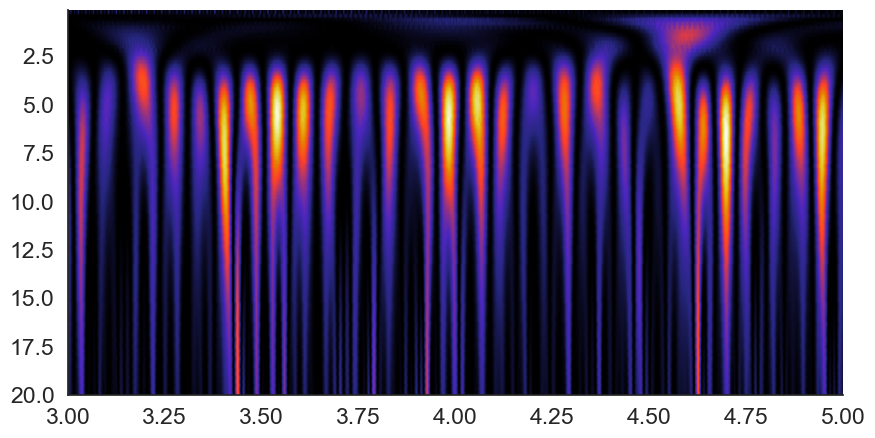

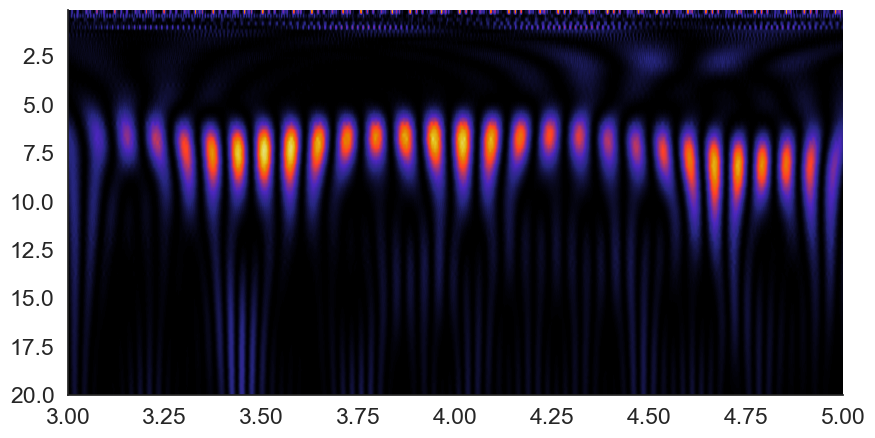

In [17]:
# using lfp from exercise 1
import scipy as sc
from pywt import scale2frequency
from pywt import cwt

f,t,sxx = sc.signal.spectrogram(lfp,fs=sampling_rate)

#spectrogram without any transform
plt.figure(figsize=(10,5))
plt.imshow(sxx,aspect='auto', cmap='CMRmap')
plt.title('Spectrogram')

#wavelet transforms
from ipywidgets import interact
import ipywidgets as widgets


def plot_wavelet(scale,freq):
    plt.figure(figsize=(10,5))
    wavelet = sc.signal.morlet(1000,s=scale,w=freq)
    envelope = abs(wavelet)
    plt.plot(wavelet.real,label='wavelet (real part)')
    plt.plot(envelope, label = 'envelope')
    plt.legend(loc=[1,1])
    plt.axis('off')

interact(plot_wavelet, scale = widgets.FloatSlider(min=.05, max=2, value=.5),
                       freq = widgets.FloatSlider(min=1, max=20, value=5))


from pywt import scale2frequency
from pywt import cwt

start = 3 #in seconds
end = 5 # in seconds

sig = lfp_full[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

#plt.figure(figsize=(10,5))
#plt.plot(sig)

#spectrogram with morlet transform (mexh)

frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet = 'mexh'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')

#spectrogram with morlet transform (gaus1)

wavelet = 'gaus1'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')

#spectrogram with morlet transform (morl)

wavelet = 'morl'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')


What differences do you see with respect to the spectrum computed with the complex Morlet transform? Comment on why do you think this might be the case.

The morlet spectrum, shows a more dense spectrum than the gaussian and mexican hat spectra.

## Exercise 3: REM sleep detection

Mammalian sleep is organized in different phases. Rapid Eye Movement (REM) sleep is a well studied phase, wtih clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep the former dominated, in a pattern that resembles active behaviour. In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

Import the data from data/moving_lfp.pickle

In [19]:
# done before in exercise 1

Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.

Text(0, 0.5, 'power (a.u.)')

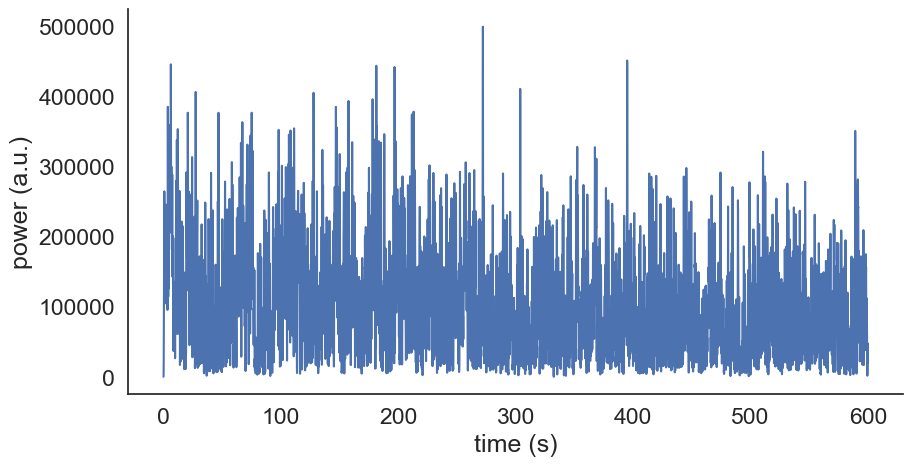

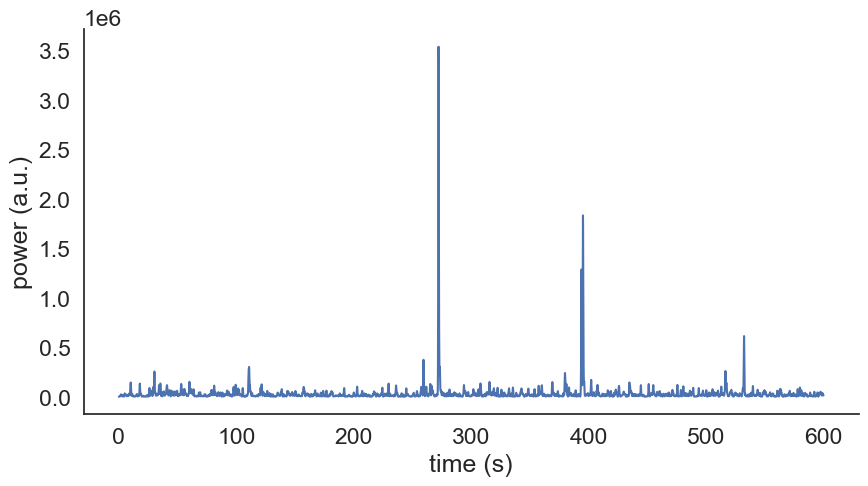

In [21]:
theta_lfp = lf.bandpass_filter(lfp_full,low_f=6,high_f=10, sampling_rate=sampling_rate)
delta_lfp = lf.bandpass_filter(lfp_full,low_f=2,high_f=4, sampling_rate=sampling_rate)

sig_theta = theta_lfp
sig_theta = sig_theta - np.mean(sig_theta) # get rid of 0 frequency component

sig_delta = delta_lfp
sig_delta = sig_delta - np.mean(sig_delta)

frequencies_theta =  np.linspace(6,10,50)/sampling_rate
frequencies_delta =  np.linspace(2,4,50)/sampling_rate
wavelet = 'cmor1.0-1.0'
scales_theta = scale2frequency(wavelet, frequencies_theta)
scales_delta = scale2frequency(wavelet, frequencies_delta)
cwtmatr_theta, _ = cwt(sig_theta, wavelet=wavelet, scales=scales_theta,
                  sampling_period=1.0/sampling_rate)
cwtmatr_delta, _ = cwt(sig_delta, wavelet=wavelet, scales=scales_delta,
                  sampling_period=1.0/sampling_rate)

power_theta = np.mean(abs(cwtmatr_theta)**2,axis=0)
power_delta = np.mean(abs(cwtmatr_delta)**2,axis=0)


plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,len(lfp_full)/sampling_rate,len(power_theta)),power_theta)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,len(lfp_full)/sampling_rate,len(power_delta)),power_delta)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')

Z-score the two power signals (subtract the mean and divide by the standard deviation, you can use scipy.stats.zscore() )

In [22]:
from scipy.stats import zscore

zscored_theta = zscore(power_theta)
zscored_delta = zscore(power_delta)

Compute and plot the power difference (theta_power - delta_power) for the sleep session.

Text(0, 0.5, 'power (a.u.)')

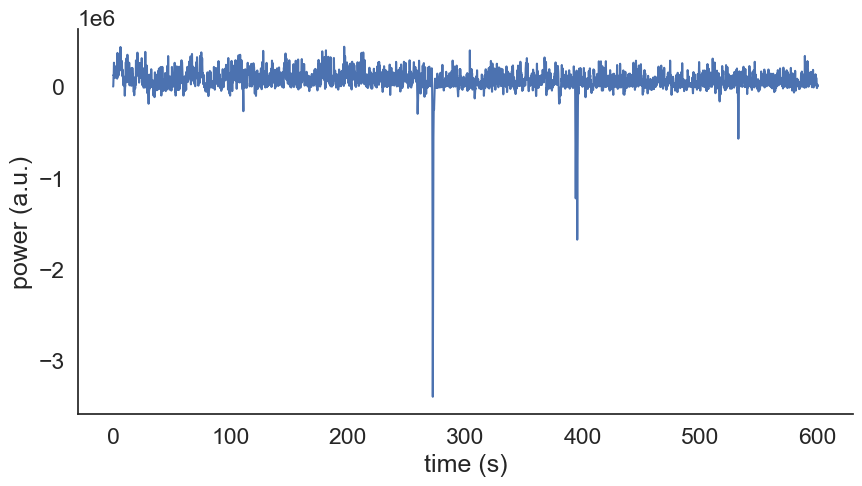

In [23]:
power_dif = power_theta - power_delta

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,len(lfp_full)/sampling_rate,len(power_dif)),power_dif)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')

Compute the REM (power difference > 0.2) and nREM (power difference < 0.2) sleep periods

In [24]:
REM = np.where(power_dif > 0.2)
nREM = np.where(power_dif < 0.2)

Plot examples of REM vs nREM lfp signals (wideband filtered between 1 and 200 Hz to get rid of some of the noise).

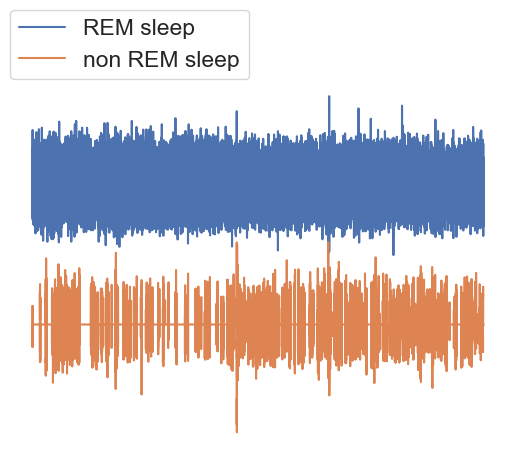

In [25]:
REM_lfp = lf.bandpass_filter(lfp_full,low_f=1,high_f=200, sampling_rate=sampling_rate)
REM_signal = np.empty(len(lfp_full))
nREM_signal = np.empty(len(lfp_full))
for i in REM:
    REM_signal[i] = REM_lfp[i]
    
for j in nREM:
    nREM_signal[j] = REM_lfp[j]
    
plt.figure()
plt.plot(np.linspace(0,len(lfp_full)/sampling_rate,len(power_dif)),REM_signal+1000,label='REM sleep')
plt.plot(np.linspace(0,len(lfp_full)/sampling_rate,len(power_dif)),nREM_signal,label='non REM sleep')
plt.axis('off')
plt.legend(loc=(0,1))

Explore how changing the threshold affects the amount of REM sleep detected.